In [1]:
%matplotlib inline

In [600]:
import numpy as np
import collections
import itertools
import matplotlib.pyplot as plt
import scipy.integrate

# Lets revise sampling methods!

We want to generate values from a particular distribution e.g. $P \sim N(0, \sigma)$, but our random number generator only gives us uniform values: $x \sim U(0, 1)$...

### (Define some functions for plotting results)

In [565]:
def plot_kept_histogram(a, b, x, u, kept):
    plt.hist(x[kept==0], bins = 20, color=(1, 1, 0, 0.5), range=(a, b))
    plt.hist(x[kept==1], bins = 20, color=(1, 0, 0, 0.7), range=(a, b))
    plt.legend(['Rejected', 'Kept = x[kept]'], loc="best")
    plt.title('Histogram of generated points')
    plt.xlabel('Values of X')
    plt.ylabel('Count')
    plt.show()
    
def plot_kept_points(a, b, x, u, kept, q=None):
    plt.hold(True)
    plt.scatter(x[kept], u[kept], marker='x')
    plt.scatter(x[kept==0], u[kept==0], marker='x', color=(0.6, 0.6, 0.6, 0.4))
    plt.plot(np.arange(a, b, 0.1), p(np.arange(a, b, 0.1)), 'r', linewidth=3)
    if q:
        plt.plot(np.arange(a, b, 0.1), q(np.arange(a, b, 0.1)), 'g', linewidth=3)
    plt.xlabel('x')
    plt.ylabel('u')
    plt.title('Plot of sampled points')
    leg = ['p(x)','Kept','Rejected']
    if q: leg = ['q(x)'] + leg
    plt.legend(leg, loc="best", framealpha=1)
    plt.axis('tight')
    plt.show()



## The rejection method


First, we define the pdf of $P$, i.e. the gaussian distribution pdf
$$p(x) = \frac{1}{\sqrt{\pi}} e^{-(x^2)}$$

In [566]:
def p(x):
    return np.exp(-(x**2)) / np.sqrt(np.pi)
p = np.vectorize(p)

### Sample the gaussian distribution using the Rejection Method
Generate samples $x_i$ and $u_i$ from uniform distributions
$$ x \sim U(a, b) $$
$$ u \sim U(0, M) $$
To sample from $P$: Accept all $x_i$ where $u_i \leq p(x_i)$, else reject $x_i$ and $u_i$

In [573]:
# Set number of samples
N = 10000
# Define the uniform distribution's rectangle
a, b, M = (-3.3, 3.3, p(0))
# Generate X∼U(a,b) and u∼U(0, M)
x = np.random.uniform(size = N)*(b-a) +a
u = np.random.uniform(size = N) * M
# Accept any points below the curve.
kept = u <= p(x)

The result: $P_i = \{x_i : u_i \leq p(x_i)\}$ samples a random variable with the desired distribution.

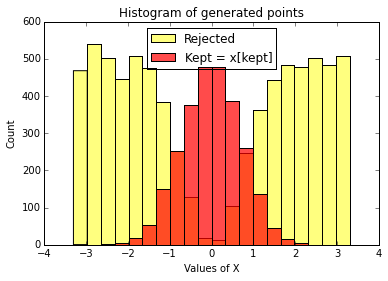

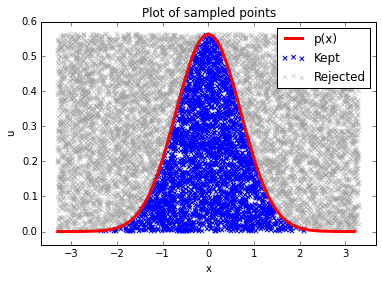

In [574]:
plot_kept_histogram(a, b, x, u, kept)
plot_kept_points(a, b, x, u, kept)

The approximate integral under $p(x)$ is given by:

$$\int_a^b p(x) = (\textrm{Size of uniform rectangle}) \times (\textrm{proportion of accepted samples})$$

In this case for the normal distribution, it should be close to 1:
$$P\sim N(0, \sigma), \qquad \int_{-\infty}^{\infty} p(x) = 1$$

In [576]:
area_under_uniform = (b-a)*M
print "Integral under curve: ", np.mean(kept) * area_under_uniform
print "{}% of samples rejected".format(1-np.mean(kept))

Integral under curve:  0.990491232876
0.734% of samples rejected


## Generalise the rejection method to allow a proposal density

Now we're able to sample some other distribution $Q(x)$ in addition to $U(x)$, but we still need $P(x)$.  that we already have values sampled under a quadratic curve...
$$ q(x) = \frac{2}{3} - \frac{x^2}{15} $$
(we don't, so we'll use the original rejection method to make some)

In [592]:
def q(x):
    return (10.0-(x**2))/15.0
q = np.vectorize(q)

N = 5000
a, b, M = (-3.3, 3.3, 0.7)
q_x = np.random.uniform(size = N) * (b - a) + a
q_u = np.random.uniform(size = N) * M
q_kept = q_u <= q(q_x)
area_under_q = (np.mean(q_kept) * (b-a) * M)
print "Integral under q(x) curve: ", area_under_q

Integral under q(x) curve:  2.788632


We sample $Q$ and $U$

$$\begin{align}
x &\sim Q(\cdot),\qquad \textrm{where } q(x) \geq p(x) \\
u &\sim U(0, 1)
\end{align} $$

And we may know that $q(x)$ is always some percentage $c$ larger than $p(x)$
$$\frac{p(x)}{q(x)} \leq c \quad \forall x$$

$u_i \cdot q(x_i)$ gives a point somewhere on the $x$ (where $x$ is chosen uniformly) axis between 0 and $q(i)$. If it is above $c \cdot p(x_i)$, reject it.

Hence, we keep all $\left\{x_i : u_i \leq \frac{p(x_i)}{c \cdot q(x_i)}\right\}$


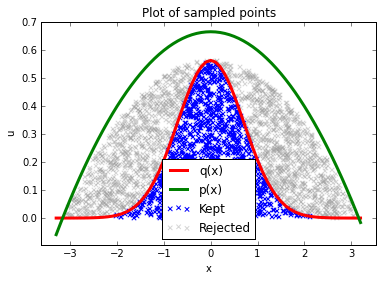

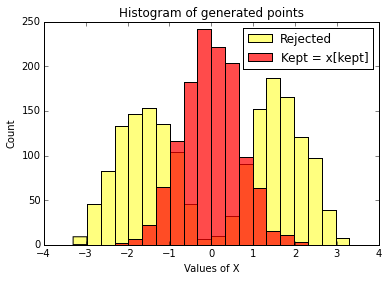

In [604]:
x = q_x[q_kept]
u = np.random.uniform(size=len(x))

# We know that p(x) is always at least some percentage
# smaller than q(x). This is largest at x=0.
c = p(0)/q(0)

# Keep points below curve * lower_bound
kept = u * c *  q(x) <= p(x)
# The histogram shows that x[kept] is
# drawn from a random distribution with density p()
plot_kept_points(a, b, x, u * q(x) * c, kept, q=q)
plot_kept_histogram(a, b, x, u, kept)

$$\int_a^b p(x) = (\textrm{Area under }q(x)) \times (\textrm{proportion of accepted samples}) \times c$$

In [622]:
print "Integral under gaussian curve: ", np.mean(kept) * area_under_q * bound
print "{}% of samples rejected".format(1-np.mean(kept))

Integral under gaussian curve:  2.35997569012
0.0% of samples rejected


Note that, because the $Q$ distribution is a closer fit to the $P$ distribution, we don't have to reject as many samples from $Q$ if we want to sample from $P$ (as compared to the uniform distribution).